In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset
import torch.nn.functional as F

import pandas as pd
import numpy as np
from PIL import Image
import tqdm
from glob import glob

# Mingxing Tan, Quoc V. Le, EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ICML 2019
from efficientnet_pytorch import EfficientNet

In [2]:
class GTSRBTrain(Dataset):
    def __init__(self):
        self.path = "GTSRB/Final_Training/Images"
        self.folder_paths = sorted(glob("{}/*/".format(self.path)))
        self.class_ind = 0
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.imgs = []
        self.lbls = []
        
        for folder_path in self.folder_paths:
            image_paths = sorted(glob("{}/*".format(folder_path)))
            # remove last csv file in the folder
            image_paths.pop()
            self.imgs += image_paths
            self.lbls += [self.class_ind] * len(image_paths)
            self.class_ind += 1

    def __getitem__(self, index):
        img = Image.open(self.imgs[index]).convert("RGB")
        img = self.img_transforms(img)
        lbl = self.lbls[index]
        return img, lbl
    
    def __len__(self):
        return len(self.imgs)

In [4]:
class GTSRBGeneric(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.imgs = []
        self.lbls = labels
        
        for filename in image_paths:
            img = Image.open(filename).convert("RGB")
            self.imgs.append(img)
        
        self.img_transforms = transform
        
    def __getitem__(self, index):
        img = self.img_transforms(self.imgs[index])
        lbl = self.lbls[index]
        return img, lbl
    
    def __len__(self):
        return len(self.imgs)

In [5]:
# Define data augmentation
grayscale_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

rotate_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

jitter_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

default_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
from sklearn.model_selection import train_test_split

train_set = GTSRBTrain()

# stratified sampling: use 20% of images in each class as the validation set
X_train, X_val, y_train, y_val = train_test_split(
        train_set.imgs, train_set.lbls, test_size=0.2, stratify=train_set.lbls, random_state=0)

train_set = GTSRBGeneric(X_train, y_train, default_transform)
val_set = GTSRBGeneric(X_val, y_val, default_transform)
print(len(train_set))
print(len(val_set))

31367
7842


In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# augment training set
train_loader = torch.utils.data.DataLoader(
   torch.utils.data.ConcatDataset(
       [train_set, GTSRBGeneric(X_train, y_train, grayscale_image),
        GTSRBGeneric(X_train, y_train, rotate_image), GTSRBGeneric(X_train, y_train, jitter_image)]
   ), batch_size=16, shuffle=True, )#num_workers=2
#)

print(len(train_loader.dataset))

val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)

125468


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # model with randomly intialized weights
        self.effNet = EfficientNet.from_name('efficientnet-b2')
        self.MLP = nn.Sequential(
            nn.Linear(1000, 200),
            nn.ReLU(),
            nn.Linear(200, 43)
        )
            
    def forward(self, x):
        x = self.effNet(x)
        x = self.MLP(x)
        return x

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("yes")
else:
    device = torch.device('cpu')
    
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

yes


In [10]:
def evaluate_acc(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(dataloader):
            outs = model(imgs.to(device))
            _, temp_preds = torch.max(outs, 1)
            total += lbls.size(0)
            temp_preds = temp_preds.cpu()
            correct += (temp_preds == lbls).sum().item()
    return correct / total

In [11]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

NUM_EPOCHS = 50
best_val_acc = 0.0
PATH = 'model.pth'

for epoch in range(NUM_EPOCHS):
    model.train()
    train_correct = 0
    for i, (imgs, lbls) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs.to(device))
        loss = criterion(outputs, lbls.to(device))
        pred = outputs.argmax(dim=1, keepdim=True).cpu()
        train_correct += pred.eq(lbls.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
    train_loss_history.append(loss.item())
    train_acc_history.append(train_correct / len(train_loader.dataset))
    
    print(epoch)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        val_loss += criterion(outputs, lbls).item()
        pred = outputs.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(lbls.view_as(pred)).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss_history.append(val_loss / len(val_loader.dataset))  
    val_acc_history.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, PATH)

0


C:\Users\Raad\WinPython\WPy64-3741\python-3.7.4.amd64\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


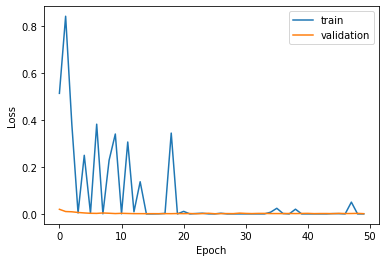

In [16]:
import matplotlib.pyplot as plt

x1 = np.arange(len(train_loss_history))
plt.plot(x1, train_loss_history)
plt.plot(x1, val_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

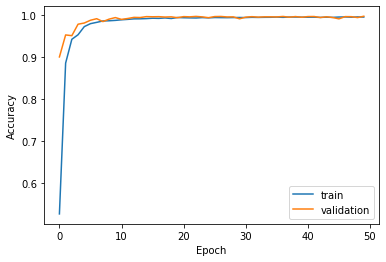

In [17]:
x2 = np.arange(len(train_acc_history))
plt.plot(x2, train_acc_history)
plt.plot(x2, val_acc_history)
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [15]:
# print(val_acc_history)
# print(val_loss_history)
# print(train_acc_history)
# print(train_loss_history)